In [1]:
import spacy
import pandas as pd
from nltk.tokenize import word_tokenize
import itertools
import re
import numpy as np
import string
from tqdm import tqdm

In [2]:
df = pd.read_excel('training&valid.xlsx')

In [3]:
def Prepro(text):
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)
    text = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('http\S+', '', text)
    return text

In [4]:
df['Tweet'] = df['Tweet'].apply(lambda x: Prepro(x))
df[['Tweet']]

,Tweet
0,Ditengah pandemi Covid19 saat ini Penyakit De...
1,Bandar Lampung Ditengah pandemi Covid19 saat...
2,dan jutaan lainnya berada di ambang kelaparan...
3,InfoKesehatan AWAS DEMAM BERDARAH mengintai ...
4,Nyamuk membawa penyakit malaria demam berdara...
...,...
739,Ciriciri penyakit tipes seringkali sulit dibe...
740,Ini makanan yang bisa mempercepat proses peny...
741,Ancaman demam berdarah dengue DBD mengintai m...
742,Cegah DBD Dikes Lobar Gelar Foggingn


In [5]:
text_ready = '.'.join(df['Tweet'])
text_ready

' Ditengah pandemi Covid19 saat ini Penyakit Demam Berdarah Dengue DBD di Kota Bandar Lampung dari Januari hinggaxe2x80xa6 . Bandar Lampung  Ditengah pandemi Covid19 saat ini Penyakit Demam Berdarah Dengue DBD di Kota Bandar Lampung daxe2x80xa6 . dan jutaan lainnya berada di ambang kelaparan Sebelum kasus pertama COVID19 dilaporkan negara ini pun mengalamixe2x80xa6 . InfoKesehatan  AWAS DEMAM BERDARAH mengintai kita Cegah dgn cara ini gtgt   INFOwargaDKI duniaWANITA. Nyamuk membawa penyakit malaria demam berdarah dll jadi bukan nyamuknya sendiri yang membunuh tetapi penyakit yang dibaw TahukahKamu. Tak Selalu Demam Berdarah Penyebab Bintik dan Merah di Badan juga Bisa Jadi Tanda Penyakit Lainnya Apa Saja . InfoKesehatan  AWAS DEMAM BERDARAH mengintai kita Cegah dgn cara ini gtgt   INFOwargaDKI duniaWANITA. Kalau di Indonesia endemik DBD tertinggi antara lain Jabar Jatim Bali DKI tapi malah 10 besar Covid Tapi kalauxe2x80xa6 . Mengenal Penyakit Demam Berdarah Dengue Sejak Dini  kontribu

In [6]:
def text_to_tagReadyDF(input):
    text = input
    punctAndSpace = string.punctuation + ' '
    
    dfList = []
    for idx, t in tqdm(enumerate(text)):
        tokens = [[word_tokenize(w), ''] for w in t.split()]
        tokens = list(itertools.chain(*list(itertools.chain(*tokens))))
        tokens = tokens[:-1]
        
        split_res = []
        for t in tokens:
                line = t.split('-')
                for i,j in enumerate(line):
                    split_res.append(j)
                    if i < len(line)-1:
                        split_res.append('-')
        
        blank = ['' if i.lower() not in list(punctAndSpace) else 'O' for i in split_res]
    
        dfTemp = pd.DataFrame([split_res, blank]).T
        dfTemp.columns = ['token_' + str(idx), 'Label_'+str(idx)]
        dfList.append(dfTemp)
    
    df = pd.concat(dfList, axis=1)

    return df

In [7]:
tagready_df = text_to_tagReadyDF([text_ready])
tagready_df

1it [00:01,  1.98s/it]


,token_0,Label_0
0,Ditengah,
1,pandemi,
2,Covid19,
3,saat,
4,ini,
...,...,...
10493,di,
10494,Pemalang,
10495,Menurun,
10496,Ini,


In [9]:
tagready_df.to_excel ('data_train.xlsx', index=False)

In [10]:
df = pd.read_excel('data_train_tagged.xlsx')

In [11]:
df.to_csv('Data/Data.tsv', sep='\t', encoding='utf-8', index=False)

In [12]:
import json
import logging
import sys
def tsv_to_json_format(input_path,output_path,unknown_label):
    try:
        f=open(input_path,'r') # input file
        fp=open(output_path, 'w') # output file
        data_dict={}
        annotations =[]
        label_dict={}
        s=''
        start=0
        for line in f:
            if line[0:len(line)-1]!='.\tO':
                word,entity=line.split('\t')
                s+=word+" "
                entity=entity[:len(entity)-1]
                if entity!=unknown_label:
                    if len(entity) != 1:
                        #print(len(entity),"Yes")
                        d={}
                        d['text']=word
                        #print(d['text'])
                        d['start']=start
                        d['end']=start+len(word)-1  
                        #print(d['start'],d['end'])
                        try:
                            label_dict[entity].append(d)
                        except:
                            label_dict[entity]=[]
                            label_dict[entity].append(d) 
                start+=len(word)+1
            else:
                data_dict['content']=s
                s=''
                label_list=[]
                for ents in list(label_dict.keys()):
                    for i in range(len(label_dict[ents])):
                        if(label_dict[ents][i]['text']!=''):
                            l=[ents,label_dict[ents][i]]
                            for j in range(i+1,len(label_dict[ents])): 
                                if(label_dict[ents][i]['text']==label_dict[ents][j]['text']):  
                                    di={}
                                    di['start']=label_dict[ents][j]['start']
                                    di['end']=label_dict[ents][j]['end']
                                    di['text']=label_dict[ents][i]['text']
                                    l.append(di)
                                    label_dict[ents][j]['text']=''
                            label_list.append(l)                          
                            
                for entities in label_list:
                    label={}
                    label['label']=[entities[0]]
                    label['points']=entities[1:]
                    annotations.append(label)
                data_dict['annotation']=annotations
                annotations=[]
                json.dump(data_dict, fp)
                fp.write('\n')
                data_dict={}
                start=0
                label_dict={}
    except Exception as e:
        logging.exception("Unable to process file" + "\n" + "error = " + str(e))
        return None

In [13]:
tsv_to_json_format("Data/Data.tsv",'Data/Data.json','abc')

In [14]:
import logging
import argparse
import sys
import os
import json
import pickle

def main(input_file, output_file):
    try:
        training_data = []
        lines=[]
        with open(input_file, 'r') as f:
            lines = f.readlines()

        for line in lines:
            data = json.loads(line)
            text = data['content']
            entities = []
            for annotation in data['annotation']:
                point = annotation['points'][0]
                labels = annotation['label']
                if not isinstance(labels, list):
                    labels = [labels]

                for label in labels:
                    entities.append((point['start'], point['end'] + 1 ,label))


            training_data.append((text, {"entities" : entities}))

        print(training_data)

        with open(output_file, 'wb') as fp:
            pickle.dump(training_data, fp)

    except Exception as e:
        logging.exception("Unable to process " + input_file + "\n" + "error = " + str(e))
        return None

In [19]:
main('Data/Data.json','Data/Data')

[('Ditengah pandemi Covid19 saat ini Penyakit Demam Berdarah Dengue DBD di Kota Bandar Lampung dari Januari hinggaxe2x80xa6 Bandar Lampung ', {'entities': [(72, 76, 'lokasi'), (77, 83, 'lokasi'), (84, 91, 'lokasi')]}), ('Ditengah pandemi Covid19 saat ini Penyakit Demam Berdarah Dengue DBD di Kota Bandar Lampung daxe2x80xa6 ', {'entities': [(72, 76, 'lokasi'), (77, 83, 'lokasi'), (84, 91, 'lokasi')]}), ('dan jutaan lainnya berada di ambang kelaparan Sebelum kasus pertama COVID19 dilaporkan negara ini pun mengalamixe2x80xa6 ', {'entities': []}), ('InfoKesehatan AWAS DEMAM BERDARAH mengintai kita Cegah dgn cara ini gtgt ', {'entities': []}), ('INFOwargaDKI duniaWANITA Nyamuk membawa penyakit malaria demam berdarah dll jadi bukan nyamuknya sendiri yang membunuh tetapi penyakit yang dibaw ', {'entities': []}), ('TahukahKamu Tak Selalu Demam Berdarah Penyebab Bintik dan Merah di Badan juga Bisa Jadi Tanda Penyakit Lainnya Apa Saja ', {'entities': []}), ('InfoKesehatan AWAS DEMAM BERDARAH men

In [16]:
import spacy
from spacy import displacy
from spacy.util import minibatch, compounding
from spacy.util import decaying
from spacy.training import Example
from spacy.tokens import Doc
import random
from matplotlib import pyplot as plt
import pickle
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [17]:
LABEL = ['lokasi', 'orang', 'organisasi', 'O']

In [18]:
def training_spacy(data, iterations):
    
    data_train = data
    nlp=spacy.blank('id')
    
    if 'ner' not in nlp.pipe_names:
        ner = nlp.add_pipe('ner', last=True)
    
    for i in LABEL:
        ner.add_label(i)
            
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']
    with nlp.disable_pipes(*other_pipes):
        
        optimizer = nlp.begin_training()
        loss_list = []
        for itn in range(iterations):
            print("Starting iteration " + str(itn))
            random.shuffle(data_train)
            losses = {}
            
            batches = minibatch(data_train, size=compounding(4.0, 32.0, 1.001))
            
            for batch in batches:
                for texts, annotations in batch:
                    doc = nlp.make_doc(texts)
                    example = Example.from_dict(doc, annotations)
                    nlp.update([example],
                               sgd=optimizer,
                               drop=0.5, 
                               losses=losses,)
            print(losses)
            loss_list.append(losses)
        
    return nlp, loss_list

In [20]:
with open ('Data/Data', 'rb') as fp:
    TRAIN_DATA = pickle.load(fp)

In [21]:
model, loss= training_spacy(TRAIN_DATA, 10)

Starting iteration 0
{'ner': 1419.1546031347514}
Starting iteration 1
{'ner': 854.9481956555617}
Starting iteration 2
{'ner': 758.7211026753646}
Starting iteration 3
{'ner': 592.4929116626716}
Starting iteration 4
{'ner': 526.3681314501056}
Starting iteration 5
{'ner': 495.68056762062025}
Starting iteration 6
{'ner': 434.2050139072606}
Starting iteration 7
{'ner': 407.0019057887148}
Starting iteration 8
{'ner': 382.27181496680555}
Starting iteration 9
{'ner': 348.31687675987615}


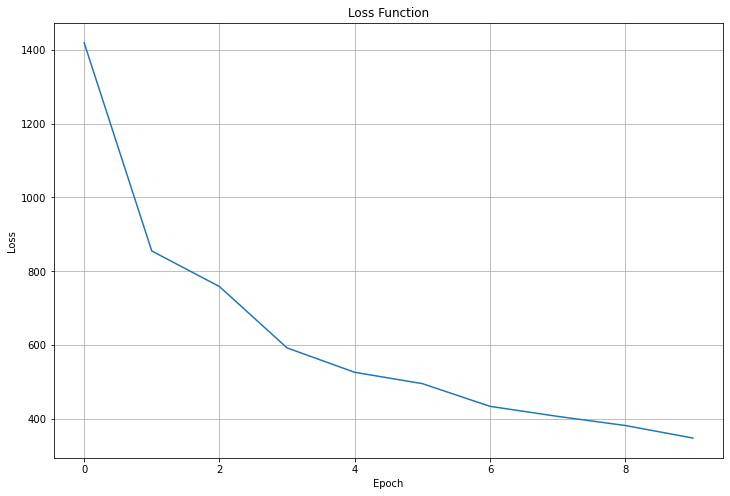

In [22]:
from matplotlib import pyplot as plt

plt.figure(figsize=(12,8))
plt.plot([i['ner'] for i in loss])
plt.grid()
plt.title('Loss Function')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [23]:
modelfile = input("Enter your Model Name: ")
model.to_disk(modelfile)

Enter your Model Name: model_ner


In [37]:
from spacy import load, displacy
link_to_model = "model_ner"
loaded_model = load(link_to_model)

In [25]:
from spacy.training import offsets_to_biluo_tags

def get_cleaned_label(label: str):
    if "-" in label:
        return label.split("-")[1]
    else:
        return label
    
def create_target_vector(doc):
    return [get_cleaned_label(label[2]) for label in doc[1]["entities"]]

def create_prediction_vector(text):
    return [get_cleaned_label(prediction) for prediction in get_all_ner_predictions(text)]

def create_total_target_vector(docs):
    target_vector = []
    for doc in docs:
        target_vector.extend(create_target_vector(doc))
    return target_vector

def create_total_prediction_vector(docs: list):
    prediction_vector = []
    for doc in docs:
        prediction_vector.extend(create_prediction_vector(doc[0]))
    return prediction_vector

def get_all_ner_predictions(text):
    doc = loaded_model(text)
    entities = [(e.start_char, e.end_char, e.label_) for e in doc.ents]
    bilou_entities = offsets_to_biluo_tags(doc, entities)
    return bilou_entities

In [26]:
def spacyformat(df):
    l1=[]
    l2=[]
    for i in range(0,len(df['token_0'])):
        l1.append(df['token_0'][i])
        l2.append({'entities':[(0,len(df['token_0'][i]),df['BIO_tag_0'][i])]})
    return list(zip(l1, l2))

In [32]:
dt = pd.read_excel('data_test_tagged.xlsx')
test = spacyformat(dt)

In [38]:
target = create_total_target_vector(test)

In [39]:
prediksi = create_total_prediction_vector(test)

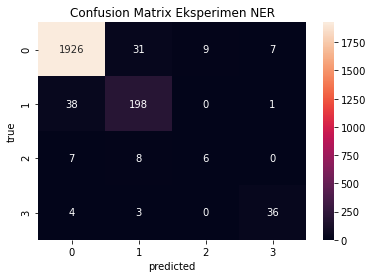

In [40]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns

sns.heatmap(confusion_matrix(target, prediksi), annot=True, fmt=".0f")
plt.title('Confusion Matrix Eksperimen NER')
plt.xlabel('predicted')
plt.ylabel('true')
plt.show()

In [41]:
from sklearn.metrics import classification_report
print(classification_report(target, prediksi))

              precision    recall  f1-score   support

           O       0.98      0.98      0.98      1973
      lokasi       0.82      0.84      0.83       237
       orang       0.40      0.29      0.33        21
  organisasi       0.82      0.84      0.83        43

    accuracy                           0.95      2274
   macro avg       0.75      0.73      0.74      2274
weighted avg       0.95      0.95      0.95      2274



In [42]:
tsv_to_json_format("Data/data_perbaikan.tsv",'Data/data_perbaikan.json','abc')

In [44]:
main('Data/data_perbaikan.json','Data/data_perbaikan')

[('Ditengah pandemi Covid19 saat ini Penyakit Demam Berdarah Dengue DBD Jendral Dokter Aceh Sumatera Utara Sumatera Barat Riau Jambi Sumatera Selatan Bengkulu Lampung Kepulauan Bangka Belitung Kepulauan Riau di Kota Bandar Lampung dari Januari hinggaxe2x80xa6 Bandar Lampung ', {'entities': [(69, 76, 'orang'), (77, 83, 'orang'), (84, 88, 'lokasi'), (89, 103, 'lokasi'), (104, 118, 'lokasi'), (119, 123, 'lokasi'), (124, 129, 'lokasi'), (130, 146, 'lokasi'), (147, 155, 'lokasi'), (156, 163, 'lokasi'), (164, 189, 'lokasi'), (190, 204, 'lokasi'), (208, 212, 'lokasi'), (213, 219, 'lokasi')]}), ('Ditengah pandemi Covid19 saat ini Penyakit Demam Berdarah Dengue DBD DKI Jakarta Jawa Barat Jawa Tengah DIY Yogyakarta Jawa Timur Banten Bali Nusa Tenggara Barat Nusa Tenggara Timur Kalimantan Barat di Kota Bandar Lampung daxe2x80xa6 ', {'entities': [(69, 80, 'lokasi'), (81, 91, 'lokasi'), (92, 103, 'lokasi'), (104, 118, 'lokasi'), (119, 129, 'lokasi'), (130, 136, 'lokasi'), (137, 141, 'lokasi'), (142

In [45]:
with open ('Data/data_perbaikan', 'rb') as fp:
    TRAIN_DATA = pickle.load(fp)

In [46]:
model, loss= training_spacy(TRAIN_DATA, 17)

Starting iteration 0
{'ner': 2501.2087943536226}
Starting iteration 1
{'ner': 2004.1474533952037}
Starting iteration 2
{'ner': 1824.4321667092836}
Starting iteration 3
{'ner': 1636.2808868625796}
Starting iteration 4
{'ner': 1549.788610822226}
Starting iteration 5
{'ner': 1478.1638360915165}
Starting iteration 6
{'ner': 1351.8230356244894}
Starting iteration 7
{'ner': 1294.0815100876573}
Starting iteration 8
{'ner': 1266.3851319172832}
Starting iteration 9
{'ner': 1170.1430620163803}
Starting iteration 10
{'ner': 1186.570226011976}
Starting iteration 11
{'ner': 1000.2590362914112}
Starting iteration 12
{'ner': 955.4217740843713}
Starting iteration 13
{'ner': 991.393872970302}
Starting iteration 14
{'ner': 932.3982395458931}
Starting iteration 15
{'ner': 860.2917317241033}
Starting iteration 16
{'ner': 856.7067603117206}


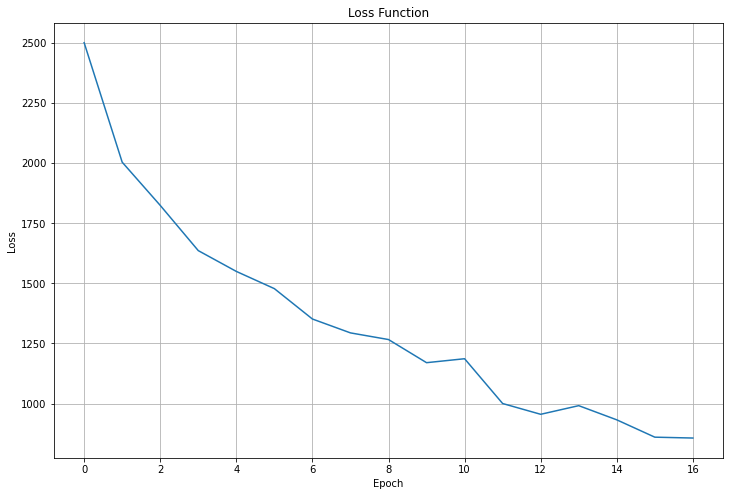

In [47]:
from matplotlib import pyplot as plt

plt.figure(figsize=(12,8))
plt.plot([i['ner'] for i in loss])
plt.grid()
plt.title('Loss Function')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [48]:
modelfile = input("Enter your Model Name: ")
model.to_disk(modelfile)

Enter your Model Name: model_ner_perbaikan


In [61]:
from spacy import load, displacy
link_to_model = "model_ner_perbaikan"
loaded_model = load(link_to_model)

In [62]:
dt = pd.read_excel('data_test_tagged.xlsx')
test = spacyformat(dt)

In [63]:
target = create_total_target_vector(test)

In [64]:
prediksi = create_total_prediction_vector(test)

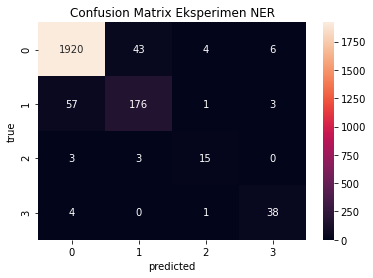

In [65]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns

sns.heatmap(confusion_matrix(target, prediksi), annot=True, fmt=".0f")
plt.title('Confusion Matrix Eksperimen NER')
plt.xlabel('predicted')
plt.ylabel('true')
plt.show()

In [66]:
from sklearn.metrics import classification_report
print(classification_report(target, prediksi))

              precision    recall  f1-score   support

           O       0.97      0.97      0.97      1973
      lokasi       0.79      0.74      0.77       237
       orang       0.71      0.71      0.71        21
  organisasi       0.81      0.88      0.84        43

    accuracy                           0.95      2274
   macro avg       0.82      0.83      0.82      2274
weighted avg       0.94      0.95      0.94      2274

